<a href="https://colab.research.google.com/github/ktongk/BTT-JPMC-1/blob/main/scrape_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [3]:
! pip install --quiet yfinance ##--quiet mutes the package list as it’s installing

In [4]:
import os
import json
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
start_date = '2023-03-02'
end_date  = '2023-03-21'

data_dir = 'data'

#A Timeline on the SVB Crash and why we Chose it

According to Investopedia, SVB Financial Group was removed from the S&P 500 Index due to the collapse its bank. So the most recent rebalancing of S&P 500 was announced on March 10, 2023.

The bank, mostly focused on venture capital funds and small tech startups had a huge boom during the pandemic. The bank then invested all of its profits into low-return bonds. However, after aggresive federal rate hikes the bonds quickly lost their value, causing panic. SVB no longer had the cash to give to the companies withdrawing their money and the FDIC took over the bank.







Initally the FDIC could only insure up to 250k but that wasn't enough, causing fear of a 2008 recession. The fed, treasury, and FDIC then announced a new emergency lending program so every company could get their money back.

##Timeseries Length
originally we were going to do the entire month of march but because there was a distinct end it didn't seem necesarry to do the full month. We decided to do a week before SVB announced their losses and then around a week after the emergency lending program was announced

##What other events did we consider?



We wanted to pick an event that had both positive and negative affects on the S&P500 companies and had a distinct beginning and end.

We considered doing the pandemic but it was too long and the rise of chatgpt but there were too many factors to consider (3.5 release, 4.0 release, 3.5 gets worse)
https://arxiv.org/pdf/2307.09009.pdf

In [7]:
names = ['','SVB announces 1.8 billion loss on bonds', 'SVB shares fall 60%, depositors withdraw money',
         'FDIC takes over SVB only insures up to 250k', 'Fed, Tresury, & FDIC say theyll cover all deposits',
         'Bank stocks bounced back in early trading','',
        ]

dates = ['2023-03-07','2023-03-08', '2023-03-09', '2023-03-10',
             '2023-03-12', '2023-03-14','2023-03-15'
        ]

    # Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

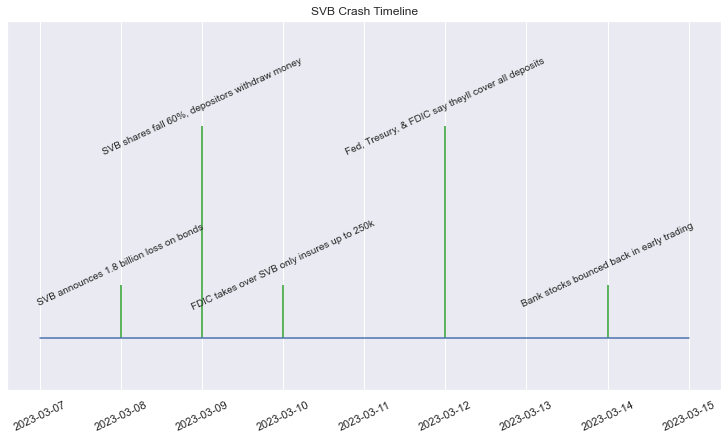

In [8]:
levels = np.tile([0, 1,4, 1, 4,1, 0], int(np.ceil(len(dates)/5)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
ax.set(title="SVB Crash Timeline")

ax.vlines(dates, 0, levels, color="tab:green")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates))  # Baseline and markers on it.



for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l), xytext=(0, 1* 20),# 0 means no horizontal offset and 1*20 means annotation will be 20 spaces from the end of the stem
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="center", rotation=25, fontsize = 10)  # Rotate the text by 45 degrees

ax.set_ylim(-1, 6)
ax.yaxis.set_visible(False)
plt.xticks(rotation=25)
plt.show()

## Google trend search of the keyword "svb" 

In [9]:
# svb_google = pd.read_csv('svb_google_trend.csv')

# import matplotlib.dates as mdates

In [10]:

# svb_google['Day'] = pd.to_datetime(svb_google['Day'])

# # Filter the DataFrame to only include dates at a five-day interval
# df_filtered = svb_google[svb_google['Day'].dt.day % 1 == 0]

# x = df_filtered['Day']
# y = df_filtered['SVB: (District of Columbia)']


# # Create a DateFormatter object
# date_formatter = mdates.DateFormatter('%m-%d')

# # Set the DateFormatter as the major formatter for the x-axis
# plt.gca().xaxis.set_major_formatter(date_formatter)

# plt.plot(x, y)

# plt.xlabel('Date')
# plt.ylabel('Interest Over Time')

# plt.title('Interest over time of "SVB"')

# plt.show()


In [11]:
# df.head()

## Get list of companies in S&P500

We will obtain and store the list of the constituents from Wikipedia.

In [12]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
table_industry = data[0]['GICS Sector']
symbols = list(table_symbol.Symbol.values) ##companies
industries = list(table_industry.values) ##Industry Sector

symbols_industries_dict = {}
symbols_industries = data[0].iloc[:, [0,2]].values.tolist()
for pair in symbols_industries:
  keys, values = pair
  symbols_industries_dict[keys] = values

print("{} symbols in total".format(len(symbols)))
print("{} industries in total".format(len(industries)))
print(industries)


503 symbols in total
503 industries in total
['Industrials', 'Industrials', 'Health Care', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Staples', 'Information Technology', 'Industrials', 'Utilities', 'Financials', 'Health Care', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Industrials', 'Materials', 'Real Estate', 'Health Care', 'Industrials', 'Utilities', 'Financials', 'Communication Services', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Utilities', 'Industrials', 'Utilities', 'Financials', 'Financials', 'Real Estate', 'Utilities', 'Financials', 'Industrials', 'Health Care', 'Information Technology', 'Information Technology', 'Information Technology', 'Financials', 'Energy', 'Information Technology', 'Information Technology', 'Consumer Discretionary', 'Financials', 'Information Technology', 'Financials', 'Financials', 'Communication Services', 'Utilities', 'Informat

## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [13]:
symbols.append('SPY')

In [14]:
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2023-03-02--2023-03-21'

In [15]:
'''
try:
  os.mkdir(data_dir)
except:
  print("Dir Error")
  '''

os.makedirs(data_dir, exist_ok=True)

In [16]:
#!ls /data


##Trying to get other types of timeseries data from yfinance
i want to get daily market cap i think

In [17]:
ticker = yf.Ticker("AAPL")
history = ticker.history(period="30d")
market_cap = history["Close"] * ticker.info["marketCap"]
market_cap.head()

Date
2023-08-31 00:00:00-04:00    5.307809e+14
2023-09-01 00:00:00-04:00    5.352731e+14
2023-09-05 00:00:00-04:00    5.359511e+14
2023-09-06 00:00:00-04:00    5.167677e+14
2023-09-07 00:00:00-04:00    5.016525e+14
Name: Close, dtype: float64

below w

In [18]:
symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-03-02 -> 2023-03-21)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1677733200, endDate = 1679371200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1677733200, endDate = 1679371200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [19]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for NVR


,Adj Close,Volume
Date,,
2023-03-02,5217.410156,22500
2023-03-03,5247.100098,16000
2023-03-06,5244.979980,22800
2023-03-07,5302.939941,23800
2023-03-08,5336.759766,30100


## Pre-process Financial Timeseries

In [20]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the month
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [21]:
# Aggregate all symbols into a price dataframe and volume dataframe
#for each ticker symbol get that csv file, set the index of that to the datetimes
#for each column in df_price is that company's adj price every datetime
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### Removing NaNs

In [22]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
df_volume.dropna(inplace=True, axis=1)
assert((df_price.index == df_volume.index).all())

In [23]:
True in pd.isna(df_price)

False

### Storing the cleaned dataframes

In [24]:
#so instead of 500 csv files its now two
df_price.to_csv(os.path.join(data_dir, "prices.csv"), index_label='date')
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

#finds percent change between current price and prior
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014496,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015593,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


In [25]:
df_price.pct_change()[1:].to_csv(os.path.join(data_dir, 'prices_pct'+dates+'.csv'), index_label='date')
df_price.to_csv(os.path.join(data_dir, 'prices'+dates+'.csv'), index_label='date')

## Obtain Percentage Change and Correlation

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from \$100 to \$110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

Spearman correlation

In [26]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### Calculate Correlations

In [27]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

In [28]:
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518886,0.791644,0.374021,0.633633,0.810017,0.844037,0.907141,0.633081,0.872987,...,0.769745,0.302470,0.665963,0.743985,0.842872,0.723937,0.581283,0.822347,0.232826,0.829995
AAL,0.518886,1.000000,0.363977,-0.151064,0.736561,0.168846,0.642950,0.615690,0.609986,0.667913,...,0.739896,-0.394523,0.452224,0.273453,0.530967,0.064474,0.102184,0.648352,0.545734,0.338240
AAPL,0.791644,0.363977,1.000000,0.431611,0.610112,0.781190,0.553825,0.815993,0.691610,0.642085,...,0.712922,0.532877,0.515753,0.803461,0.644941,0.761709,0.446680,0.716757,0.305478,0.782669
ABBV,0.374021,-0.151064,0.431611,1.000000,0.339879,0.705052,0.322699,0.290110,0.224161,0.327989,...,0.359327,0.294439,0.311519,0.674334,0.404991,0.548516,0.709123,0.218785,0.018604,0.133280
ABNB,0.633633,0.736561,0.610112,0.339879,1.000000,0.482642,0.751249,0.783877,0.845854,0.700262,...,0.805316,-0.174716,0.398855,0.569476,0.545922,0.349104,0.265398,0.693478,0.571563,0.435600


Text(0.5, 1.0, 'Correlation heatmap for Volume')

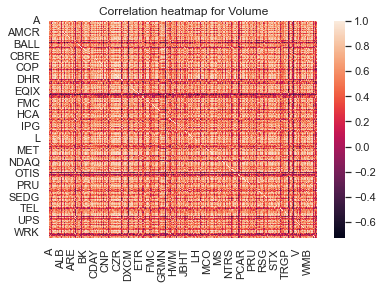

In [29]:
sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

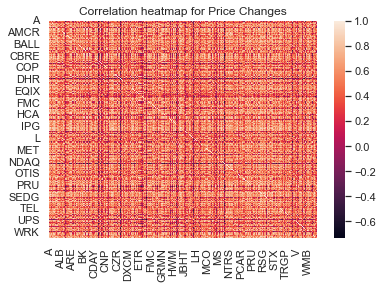

In [30]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### Examining correlations further

In [31]:
df_price_pct['JPM'].head()

2023-03-03    0.018360
2023-03-06   -0.005847
2023-03-07   -0.029408
2023-03-08   -0.005915
2023-03-09   -0.054136
Name: JPM, dtype: float64

Text(0.5, 1.0, 'Price Change Scatterplot between JPM and GS. Correlation = 0.5898310965704259')

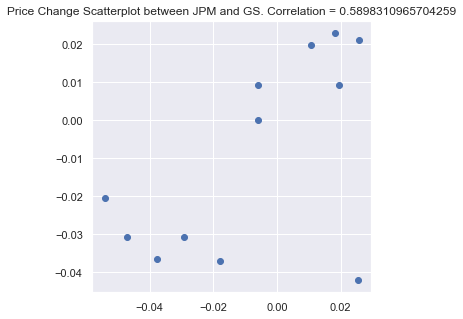

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

Summary statistics for the df_price_pct and df_volume dataframes and then boxplots to find outliers

In [33]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015953,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016332,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004864,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014496,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021774,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015593,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012676,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


# Summary Stats and Outliers?
The below box plot is showing the price percentage change averaged across all 500 companies for each day, there's no outliers so it doesn't seem like theres one day in the timeseries where all the companies are all having drastic movement.




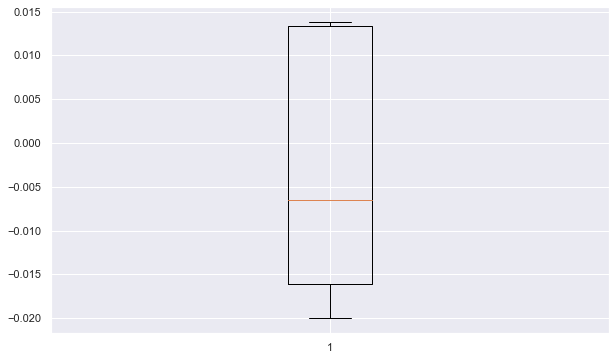

count    12.000000
mean     -0.003664
std       0.014240
min      -0.020039
25%      -0.016096
50%      -0.006483
75%       0.013305
max       0.013809
Name: average, dtype: float64

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
df_price_plotting = df_price_pct
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day



# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

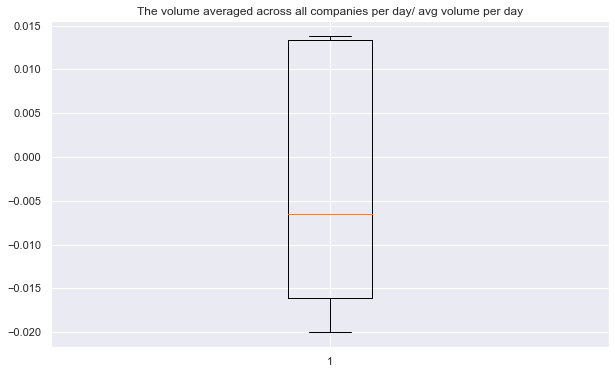

count    12.000000
mean     -0.003664
std       0.014240
min      -0.020039
25%      -0.016096
50%      -0.006483
75%       0.013305
max       0.013809
Name: average, dtype: float64

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="The volume averaged across all companies per day/ avg volume per day")
df_volume_summary_stats = df_volume.describe()
df_volume_summary_stats['average'] = df_volume_summary_stats.mean(axis=1)
df_volume_summary_stats['average']


# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

### Analyzng the distributions over time

This time instead of averaging every companies price change per day we're going to look at every company's price change over one day and make a separate boxplot to show the changes in distribution across the week of the crash

on march 2nd there was  3  negative outliers and  13 positive outliers in the distribution
on march 9th there was  21  negative outliers and  3 positive outliers in the distribution
on march 15th there was  9  negative outliers and  14 positive outliers in the distribution
on march 19th there was  10  negative outliers and  10 positive outliers in the distribution




[Text(0.5, 1.0, 'Price % changes on march 19th 2023')]

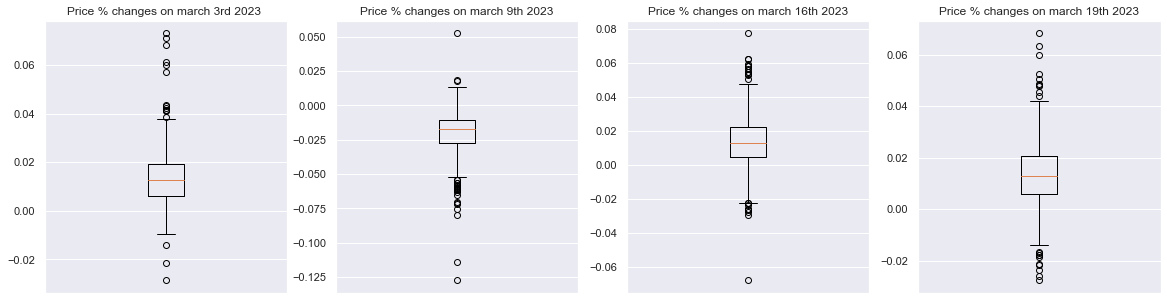

In [36]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 5), ncols=4)
bxplt1 = ax1.boxplot(df_price_pct.loc['2023-03-03'])
bxplt2 = ax2.boxplot(df_price_pct.loc['2023-03-09'])
bxplt3 = ax3.boxplot(df_price_pct.loc['2023-03-16'])
bxplt4 = ax4.boxplot(df_price_pct.loc['2023-03-20'])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

outliers1 = bxplt1["fliers"][0].get_ydata()
outliers2 = bxplt2["fliers"][0].get_ydata()
outliers3 = bxplt3['fliers'][0].get_ydata()
outliers4 = bxplt4['fliers'][0].get_ydata()

neg_outliers1 = outliers1[outliers1<0]
neg_outliers2 = outliers2[outliers2<0]


print('on march 2nd there was ', len(neg_outliers1), ' negative outliers and ', len(outliers1[outliers1>0]), 'positive outliers in the distribution')
print('on march 9th there was ', len(neg_outliers2), ' negative outliers and ', len(outliers2[outliers2>0]), 'positive outliers in the distribution')
print('on march 15th there was ', len(outliers3[outliers3<0]), ' negative outliers and ', len(outliers3[outliers3>0]), 'positive outliers in the distribution')
print('on march 19th there was ', len(outliers4[outliers4<0]), ' negative outliers and ', len(outliers4[outliers4<0]), 'positive outliers in the distribution\n\n')

ax1.set(title="Price % changes on march 3rd 2023 ")
ax2.set(title="Price % changes on march 9th 2023")
ax3.set(title= "Price % changes on march 16th 2023")
ax4.set(title = "Price % changes on march 19th 2023")


This is also shown in the line graph showing how during the week of the crash, healthcare company ABT stayed consistent with the monthly trends while financial company charles schwab had one of its lowest price drops. Tesla, a silicon tech company had big drop on the 9th but rebounded pretty quickly

I wanted to show how the crash affects other sectors besides financial

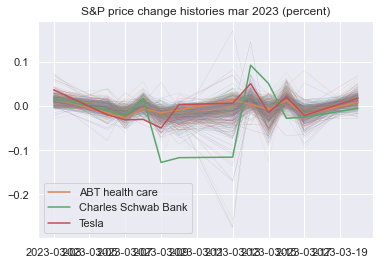

In [37]:
plt.title('S&P price change histories mar 2023 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.plot(df_price_pct['ABT'], label='ABT health care', linewidth=1.5)
plt.plot(df_price_pct['SCHW'], label = 'Charles Schwab Bank', linewidth=1.5)
plt.plot(df_price_pct['TSLA'], label = 'Tesla', linewidth=1.5)
plt.legend()

## <font color= "9900CC">**Not every company reacted the same way**
In the original time series used for the file, JPMC and GS's price changes were consistent with each other throughout the month. However, when we set the timeseries to march 2023, during the week of the SVB crash they diverge drastically, this is because while GS suffered due to uncertaintiy w/ the economy, JPMC was in talks to accquire SVB thus their price sky rocketed so you can't definetively say every financial company suffered due to the crash.

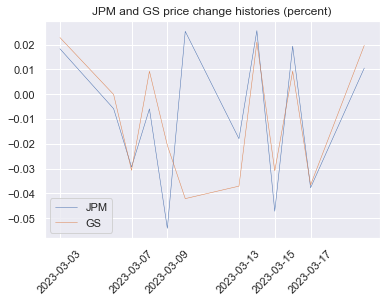

In [38]:
plt.title('JPM and GS price change histories (percent)')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
dates = list(df_price_pct.index.values)
plt.xticks([dates[i] for i in range(len(dates)) if i % 2 == 0], rotation=45)
plt.legend()

In [39]:
df_price_pct_summary_stats = df_price_pct.describe()
df_price_pct_summary_stats['average'] = df_price_pct_summary_stats.mean(axis=1)
print('summary statistics for price (not pct change) averaged across all companies')
#df_price_pct_summary_stats.head()
print(df_price_pct_summary_stats['average'])

summary statistics for price (not pct change) averaged across all companies
count    12.000000
mean     -0.003664
std       0.020199
min      -0.037164
25%      -0.017010
50%      -0.003807
75%       0.009749
max       0.029084
Name: average, dtype: float64


## Saving correlation dataframes

In [40]:
#df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'), index_label='date')
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'), index_label='Symbol')
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))

## CREATE A HEATMAP WITH THRESHOLD OF ONLY ABOVE 0.7

Text(0.5, 1.0, 'Price Correlation Heatmap')

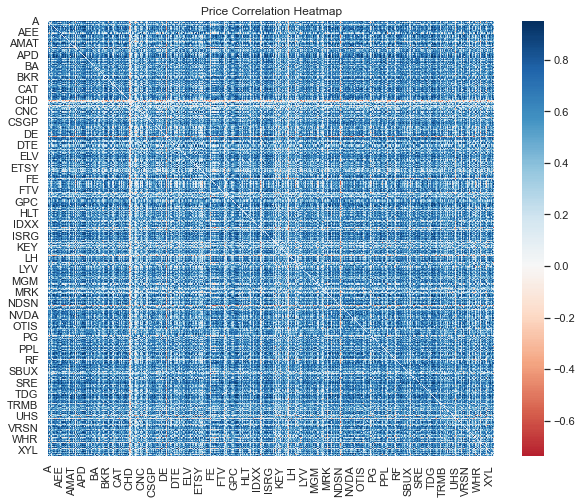

In [41]:

# threshold = 0.7
threshold = 0.95

# Create a mask to hide the upper triangle of the heatmap
mask = price_corr.abs() > threshold

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(price_corr, cmap='RdBu', mask=mask, center=0)
plt.title('Price Correlation Heatmap')


## Use the price corr matrix to graph the correlation

In [42]:
import networkx as nx
import plotly.graph_objects as go

In [43]:
threshold = .95

links = price_corr.stack().reset_index()
links.columns = ['company1', 'company2', 'correlation']
#made price_corr go from company names as the row and column indeces to company1 being the first column header, company2 beign the second, and correlation as the third

#filtering out any correlations under the threshold that we will set and getting rid of the self loops in the nodes
links_filtered=links.loc[ (links['correlation'] > threshold) & (links['company1'] != links['company2']) ]
G=nx.from_pandas_edgelist(links_filtered, 'company1', 'company2', edge_attr = 'correlation')
nodes = list(G.nodes)
#df_company_names = pd.DataFrame(nodes, columns=['S&P Names'])
nx.set_node_attributes(G, symbols_industries_dict, 'GICS Sector')



## Adding weights to the edges

I'm going to make the edge color on the graph be a darker blue if the correlation is higher between the nodes

in the code above i set an edge attribute as 'correlation' now im iterating through the links_filtered to get two lists: edges (s,d) and weight (correlation)

in the code block below i set the edgelist to that edges list i just made and set the edge_color to the weights themselves, the colors and numbers map based on the edge c_map (color_map) called plt.cm.Blues

In [44]:
edges = []
weights = []

# Iterate through the edges of the graph and extract 'correlation' as weights
#were making an edges list and a weights list
for edge in G.edges(data=True):
    source, target, weight = edge
    edges.append((source, target))
    weights.append(weight['correlation'])



G is the graph but now I'm playing with different ways to visualize it, the original briefing video mentioned making an interactive graph so i'm going to try that. below is the standard static graph that doesn't tell us much.  you can still tell which nodes are central and which are outliers relative to each other though.

In [45]:
# Making a custom node color map based on sector


val_map = {
    'Materials': 'navy',
    'Consumer Staples': 'purple',
    'Energy': 'teal',
    'Real Estate': 'cyan',
    'Information Technology': 'dodgerblue',
    'Utilities': 'blue',
    'Health Care': 'indigo',
    'Industrials': 'royalblue',
    'Consumer Discretionary': 'skyblue',
    'Communication Services': 'midnightblue',
    'Financials': 'steelblue'
}

#list comprehension cool
node_colors = [val_map.get(G.nodes[node]['GICS Sector']) for node in G.nodes()]

Drawing the network with the custom node color map and edge colormap

it should be noted that i cant make a colormap for the node colors (i could for edges tho) the node colors have literally nothing to do with each other just if its the same color its the same industry

for the edge colors, if the edge is lighter, then the correlation is weaker

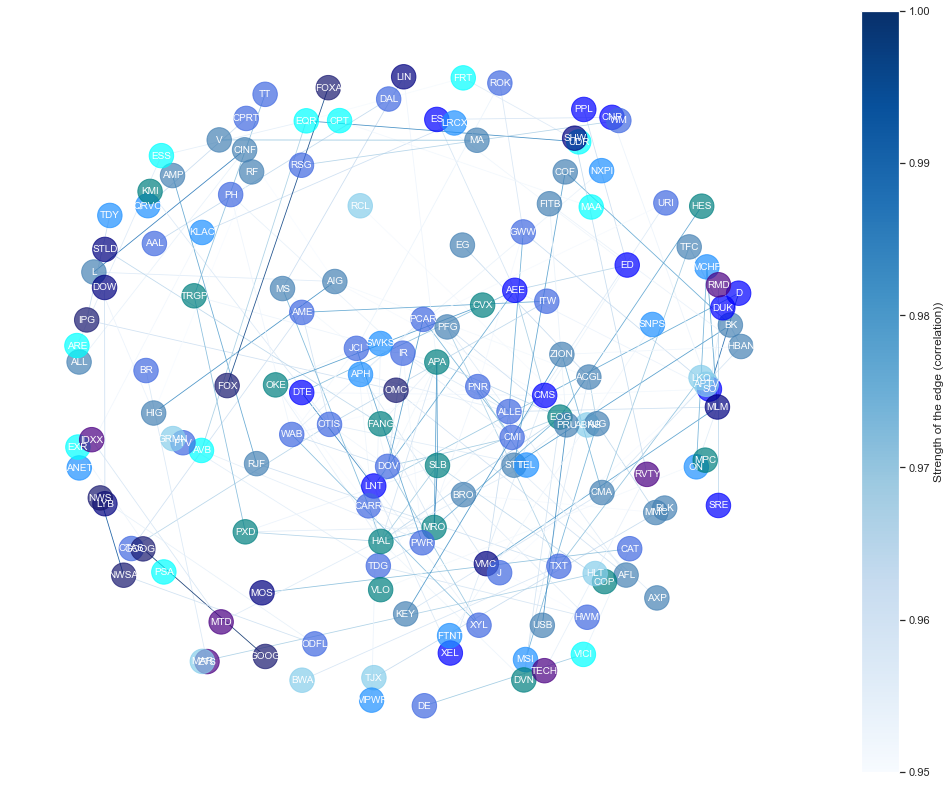

In [46]:
from matplotlib import cm
plt.figure(figsize=(18, 14))


pos = nx.spring_layout(G, k=.7, seed =1234)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodes,
                       node_size=600,
                       node_color=node_colors,
                       alpha=.7)
nx.draw_networkx_edges(G,pos,
                       edgelist = edges,
                       width=.8,
                       edge_color= weights,
                       edge_cmap = plt.cm.Blues,
                       alpha=0.9)


nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodes,nodes)),
                        font_color='white',
                        font_size = 10)

cmap = cm.ScalarMappable(cmap=cm.Blues, norm=plt.Normalize(vmin=threshold, vmax=1))
# Add colorbar directly to the plot
cbar = plt.colorbar(cmap)
cbar.set_label('Strength of the edge (correlation))')

plt.box(False)
plt.show()


## Make it interactive

In [47]:
pos = nx.spring_layout(G, seed=1234) #seed for reproducibility
nx.set_node_attributes(G, pos, 'pos')

In [48]:
# hover text
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(nodes[node]+' # of connections: '+str(len(adjacencies[1])))

## Edge Trace
So for plotly you cant just import a premade graph you have to trace over every node and edge and put into the plotly scatter plot

uses the spring layout positions to get the coordinates of the first node and second node in the edge to make the edge_x[] and edge_y[]

edge trace takes those arrays and traces them with a thin grey line

In [49]:
###Custom Color Map for the edges you cant use a colorscale i think i need to do this manually

import matplotlib.cm as cm
normalized_weights = (np.array(weights) - min(weights)) / (max(weights) - min(weights))
num_intervals = 10
colors = np.linspace(0, 1, num_intervals) #start stop intervals

In [50]:
import plotly.graph_objects as go

In [51]:
edge_traces = []

for i, edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    # set the color for the current edge based on the normalized weight
    #going to do rgb for the colors
    color_index = int(normalized_weights[i] * (num_intervals - 1))
    color_rgb = f"rgb({int(colors[color_index] * 255)}, {int(colors[color_index] * 255)}, {int(colors[color_index] * 255)}  )" #so because the three rgb values are equal its just going to be in greyscale lol
    edge_trace = go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        #hoverinfo='text',
        mode='lines',
        hoverinfo = 'text',
        line=dict(
            width=1.5,
            color=color_rgb,
        )
    )

    edge_traces.append(edge_trace)


## Node Trace
this is setting up the hovertext and the normal text (labels) for the nodes
you set the mode to markers+text to show the labels and the circles, if you do markers+text+lines it'll show additional lines (edges) between nodes that dont make sense in the marker attribute were setting up for the node's color to be depedent on the num of adjacancies

Then custom node color map these colors have nothing to do with each other !!!!!

In [52]:
node_colors = [val_map.get(G.nodes[node]['GICS Sector']) for node in G.nodes()]

# Node Positions
node_x = []
node_y = []

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

# Node Trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    hoverinfo='text',
    text=list(G.nodes()),
    hovertext=node_text,
    textposition='top right',
    mode='markers+text',
    marker=dict(
        color=node_colors,
        size=10,
        line_width=1
    ))

In [53]:
# ! pip install --upgrade nbformat

In [54]:
fig = go.Figure(data=edge_traces + [node_trace],
             layout=go.Layout(
                title='<br>Correlation of S&P Companies based on Price Change',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Show the Figure
fig.show()

<b>Correlation Analysis - clustering</b><br></br>
Group companies together using clustering techniques
Then, apply statistical methods, such as correlation analysis, to identify relationships and patterns within the company graph


Hiericharical clustering:
- Distance computing 

Dendrogram: 
- Single linkage
        - A distance between clusters in the tree is calculated using the shortest distance between them.
- Average linkage (UPGMA) - A distance between clusters in the tree is calculated using average distance between them.
- Complete linkage - A distance between clusters in the tree is calculated using the longest distance between them.
- Ward - At every step of clustering two clusters that result into a minimal loss of information are combined. Information loss is measured using error sum-of-squares criterion.




Steps for clustering based on price change:
step 0: decide the number of clusters required, which is the threshold of abs value of 95%
step 1: create a scatter plot
step 2: normalize the data
step 3: calculate eclidean distance
step 4: create a dendogram



In [55]:
import os
import numpy as np

def remove_text_from_correlation_matrix(correlation_matrix):
    """Removes the text from the first row and first column of a correlation matrix.

    Args:
        correlation_matrix: A NumPy array containing the correlation matrix.

    Returns:
        A NumPy array containing the correlation matrix without the text.
    """

    # Remove the first row.
    correlation_matrix = correlation_matrix[1:]

    # Remove the first column.
    correlation_matrix = correlation_matrix[:, 1:]

    return correlation_matrix

# Get the path to the price_corr.csv file
price_corr_file_path = 'data/price_corr.csv'

# Load the CSV file, specifying which columns to use (skip the first column and row)
correlation_matrix = np.loadtxt(price_corr_file_path, delimiter=',', skiprows=1, usecols=range(1, 11))

# Remove the text from the correlation matrix.
correlation_matrix = remove_text_from_correlation_matrix(correlation_matrix)


In [56]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

In [132]:
# computer distance matrix with euclidean distance
distance_matrix = pdist(price_corr, metric='euclidean')
full_price_distance= squareform(distance_matrix)
print(full_price_distance)

[[0.         8.23294312 3.67687366 ... 2.93683702 9.62802578 3.86853013]
 [8.23294312 0.         9.13086255 ... 7.74077297 4.74270443 9.01501858]
 [3.67687366 9.13086255 0.         ... 4.20737831 9.54133046 3.03087106]
 ...
 [2.93683702 7.74077297 4.20737831 ... 0.         8.5384145  4.41034751]
 [9.62802578 4.74270443 9.54133046 ... 8.5384145  0.         9.95313287]
 [3.86853013 9.01501858 3.03087106 ... 4.41034751 9.95313287 0.        ]]


In [133]:
print(correlation_matrix)

[[ 1.          0.3639773  -0.15106388 ...  0.61569007  0.60998579
   0.66791253]
 [ 0.3639773   1.          0.43161108 ...  0.81599259  0.69160998
   0.64208509]
 [-0.15106388  0.43161108  1.         ...  0.29011005  0.22416068
   0.32798914]
 ...
 [ 0.64835185  0.71675722  0.21878485 ...  0.80657795  0.80199538
   0.91304074]
 [ 0.54573428  0.30547789  0.01860369 ...  0.41610408  0.62616019
   0.37171769]
 [ 0.33823979  0.78266926  0.13328005 ...  0.80615968  0.65227462
   0.69322151]]


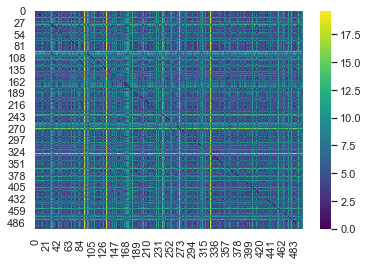

In [134]:
# Create a heatmap

sns.heatmap(full_price_distance, cmap='viridis', cbar=True)

# Display the heatmap
plt.show()

/var/folders/2d/mczz2l2s61q31g72202cfm3w0000gn/T/ipykernel_27764/4139539529.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



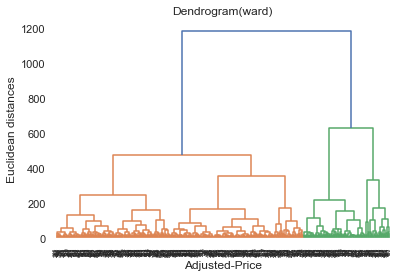

In [135]:
# sofia's dendrogram
dendrogram = sch.dendrogram(sch.linkage(full_price_distance, method  = "ward"))

plt.title('Dendrogram(ward)')
plt.xlabel('Adjusted-Price')
plt.ylabel('Euclidean distances')
plt.show()

Now we have the dendrogram, it's all together. We can't tell much. So let's divide it up to multiple clusters. 

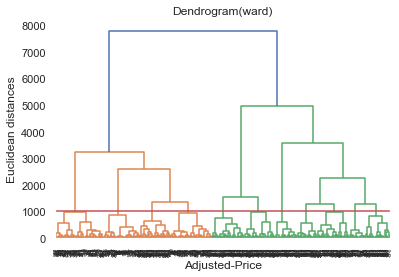

In [174]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

distances = linkage(price_corr, metric='euclidean')

# Should I add a threshold here? (with distace_threshold parameter)
clusters = linkage(distances, 'ward')

dendrogram(clusters)
plt.axhline(y = 1000, color = 'r', linestyle = '-')
plt.title('Dendrogram(ward)')
plt.xlabel('Adjusted-Price')
plt.ylabel('Euclidean distances')
plt.show()





In [166]:
import numpy as np
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at 10 clusters
cluster_labels = fcluster(clusters, 10, 'maxclust')

# Get the unique cluster labels
unique_cluster_labels = np.unique(cluster_labels)

print("the unique cluster labels and the number of price correlation values in each cluster are as follows(10 clusters)")
for cluster_label in unique_cluster_labels:
    count = np.count_nonzero(cluster_labels == cluster_label)
    print(f'Cluster {cluster_label}: {count}')

# Identify the cluster with the highest number of price correlation values
cluster_with_highest_count = np.argmax(np.unique(cluster_labels))




the unique cluster labels and the number of price correlation values in each cluster are as follows(10 clusters)
Cluster 1: 72
Cluster 2: 55
Cluster 3: 45
Cluster 4: 61
Cluster 5: 49
Cluster 6: 45
Cluster 7: 34
Cluster 8: 77
Cluster 9: 25
Cluster 10: 36


In [ ]:
#tree map or scatter plot 
